In [3]:
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((150, 150)),  # Укажи нужный размер
            transforms.ToTensor(),
        ])

        self.class_to_idx = {
            cls_name: idx
            for idx, cls_name in enumerate(
                sorted(
                    d for d in os.listdir(root_dir)
                    if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith('.')
                )
            )
        }

        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}


        self.samples = []
        for cls_name in self.class_to_idx:
            cls_folder = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(('.png', '.jpg', 'jpeg', '.bmp')):
                    self.samples.append((os.path.join(cls_folder, fname), self.class_to_idx[cls_name]))



    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0

        return img, label



class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 18 * 18, 128)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
!cp -r "/content/drive/MyDrive/archive (7)/seg_train" /content/

In [ ]:
dataset = ImageDataset("/content/seg_train/seg_train")
loader = DataLoader(dataset, batch_size=512, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 600

l = []

for epoch in range(num_epochs):
    for batch in loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        prediction = model(inputs)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()

    print(f"epoch: {epoch}, loss: {loss.item()}")
    l.append(loss.item())


PATH = '/content/drive/MyDrive/archive (7)/my_image_classifier.pth'
torch.save(model.state_dict(), PATH)
print(f"Модель сохранена по пути: {PATH}")


plt.plot(l)
plt.show()

epoch: 0, loss: 1.527177333831787


Найдено классов в тестовом наборе: 6
Количество изображений в тестовом наборе: 3000

Отображение первых 10 картинок с предсказанными классами...


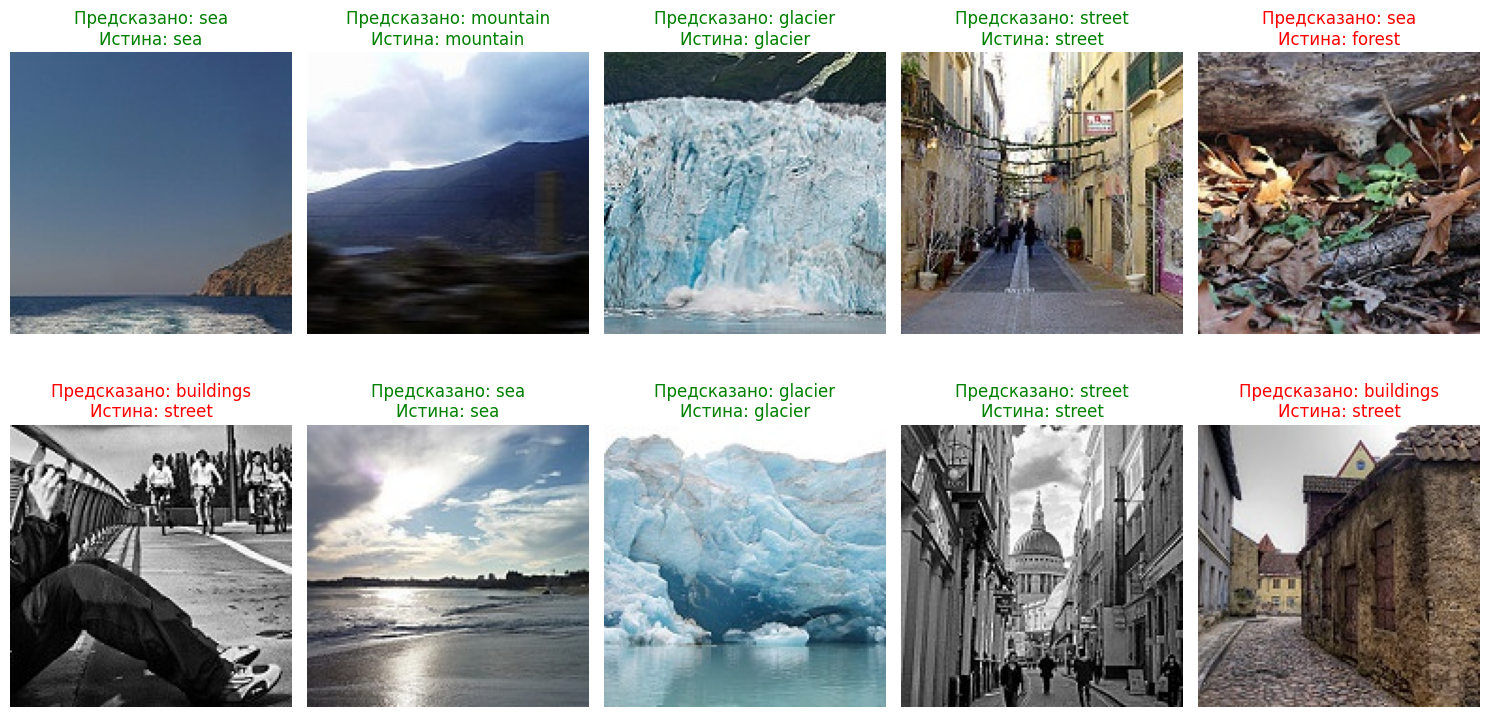

In [4]:
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms


MODEL_PATH = '/content/drive/MyDrive/archive (7)/my_image_classifier.pth'
device = torch.device('cpu')
model = CNN()
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)

model.eval()
# --- 4. Загрузка тестовых данных ---
test_root_dir = "/content/drive/MyDrive/archive (7)/seg_test/seg_test"
test_dataset = ImageDataset(test_root_dir)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)  # Берем батч 10 для простоты отображения

print(f"Найдено классов в тестовом наборе: {len(test_dataset.class_to_idx)}")
print(f"Количество изображений в тестовом наборе: {len(test_dataset)}")

# --- 5. Оценка модели (общая точность) ---
correct = 0
total = 0
class_correct = list(0. for i in range(len(test_dataset.class_to_idx)))
class_total = list(0. for i in range(len(test_dataset.class_to_idx)))

'''print("Начало оценки модели на тестовом наборе...")
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Оценка"):  # Измененный DataLoader возвращает 3 элемента
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

accuracy = 100 * correct / total
print(f'\nТочность модели на {total} тестовых изображениях: {accuracy:.2f}%')
'''
'''print("\nТочность по каждому классу:")
for i in range(len(test_dataset.class_to_idx)):
    if class_total[i] > 0:
        print(f'  Класс {test_dataset.idx_to_class[i]} ({i}): {100 * class_correct[i] / class_total[i]:.2f}%')
    else:
        print(f'  Класс {test_dataset.idx_to_class[i]} ({i}): Нет примеров в тестовом наборе')
'''
# --- 6. Визуализация первых 10 картинок с предсказаниями ---
print("\nОтображение первых 10 картинок с предсказанными классами...")


display_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# Получаем первый батч
dataiter = iter(display_loader)
images_tensor, labels_tensor = next(dataiter)

# Переводим изображения на устройство и делаем предсказания
images_tensor = images_tensor.to(device)
labels_tensor = labels_tensor.to(device)

with torch.no_grad():
    outputs = model(images_tensor)
    _, predicted_indices = torch.max(outputs, 1)

plt.figure(figsize=(15, 8))  # Увеличиваем размер фигуры

for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Преобразуем тензор обратно в изображение (с учётом нормализации, если была)
    img = images_tensor[i].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # на случай, если значения выходят за пределы [0, 1]

    plt.imshow(img)

    true_class = test_dataset.idx_to_class[labels_tensor[i].item()]
    predicted_class = test_dataset.idx_to_class[predicted_indices[i].item()]

    color = "green" if predicted_class == true_class else "red"

    plt.title(f"Предсказано: {predicted_class}\nИстина: {true_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()



